## VGG16 architecture on the CIFAR10 dataset

To explore explainability of a neural network we start from a first simple architecture and a simple dataset as a reference.  Therefore, we choose to start from the VGG16 acrhitecture and a CIFAR 10 dataset. 

CIFAR10 is a smaller dataset containing only 10 different classes and the images have a resoultion of 32x32. For the sake of curiosity, we decided to train the same architecture VGG16 in two different ways:

1. The VGG16 architecture can be found pretrained on the ImageNet dataset and it is possible to tune it on the chosen CIFAR10 dataset. We perfomr the so called Transfer learning
2. The alternative solution is training directly the architecture on CIFAR10

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torchvision.models import vgg16
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10

use_cuda = torch.cuda.is_available()
cuda_index = torch.cuda.device_count() - 4
device = torch.device(f"cuda:{cuda_index}" if use_cuda else "cpu")
print(f"Using {device} device")
abs_data_path = 'newpenny/XAI/pytorch/zennit/docs/source/data/CIFAR10'


# definition of some of the hyperparameters used for the training
num_epochs = 2000
batch_size = 64
learning_rate = 0.001
classes = ('plane', 'car' , 'bird',
    'cat', 'deer', 'dog',
    'frog', 'horse', 'ship', 'truck')

/home/lorenzocapelli/miniconda3/envs/tesi/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using cuda:4 device


We adapted the dataset CIFAR10 to the architecture VGG16. The images contained in CIFAR10 have a resolution of 32x32 while the first layer of VGG16 requires as a layer a tensor with resolution 224x224. As a consequence, we decided to oversample the given images in order to be coherent to the given architecture

In [2]:
transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize( 
       (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010) 
    )
])

cifar_dataset = CIFAR10(root=abs_data_path, 
                        train=True, 
                        transform=transform, 
                        download=True)

# split the dataset into train and validation sets
seed=29
train_size = int(0.8 * len(cifar_dataset))
val_size = len(cifar_dataset) - train_size
train_dataset, val_dataset = random_split(cifar_dataset,
                                          [train_size, val_size],
                                            generator=torch.Generator().manual_seed(seed))

# create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


Files already downloaded and verified


In [3]:
test_dataset = torchvision.datasets.CIFAR10(root=abs_data_path, 
                                            train=False, 
                                            download=True, 
                                            transform=transform)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified


In [4]:
for i, (imgs , labels) in enumerate(train_loader):
    #imgs = imgs.to(device)
    #labels = labels.to(device)
    imgs=imgs.detach().to('cpu').numpy()
    print(imgs.shape)
    break
    

(64, 3, 224, 224)


### VGG16 PRETRAINED 

At this point we downloaded the ImageNet pretrained VGG16 architecture and we just modified the last FC-layer, because in our case instead of having 1000 classes we have just 10 of them.

In [11]:
model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [12]:
input_lastLayer = model.classifier[6].in_features
model.classifier[6] = nn.Linear(input_lastLayer,10)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum=0.9,weight_decay=5e-4)

In [13]:
early_stopping_patience = 20
# we set it to infinite at the beeginning any number is smaller than infnite
best_val_loss = float('inf')
patience_counter = 0

In [14]:
def accuracy(outputs, targets):
    _, predicted = torch.max(outputs, 1)  # get the class index with the highest probability
    correct = (predicted == targets).sum().item()
    total = targets.size(0)
    return correct / total

#### Train

In [15]:
num_epochs = 2000
patience_counter = 0
path='models/pretrained-VGG16-CIFAR10-version2'

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    for data in train_loader:
        inputs, targets = data
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        correct_predictions += accuracy(outputs, targets) * targets.size(0)
        total_predictions += targets.size(0)

    # Calculate validation loss
    model.eval()
    val_loss = 0.0
    val_correct_predictions = 0
    val_total_predictions = 0
    
    with torch.no_grad():
        for data in val_loader:
            inputs, targets = data
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            
            val_correct_predictions += accuracy(outputs, targets) * targets.size(0)
            val_total_predictions += targets.size(0)
            
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    
    train_accuracy = (correct_predictions / total_predictions) * 100
    val_accuracy = (val_correct_predictions / val_total_predictions) * 100
    
    #print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, '
          f'Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%')
    
    # Early stopping check
    if val_loss < best_val_loss:
        torch.save(model.state_dict(), path)
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print("Early stopping: Validation loss hasn't improved for", early_stopping_patience, "epochs.")
            break


Epoch [1/2000], Train Loss: 0.4814, Val Loss: 0.2879, Train Accuracy: 83.49%, Val Accuracy: 90.25%
Epoch [2/2000], Train Loss: 0.2385, Val Loss: 0.2346, Train Accuracy: 91.85%, Val Accuracy: 92.16%
Epoch [3/2000], Train Loss: 0.1518, Val Loss: 0.2495, Train Accuracy: 94.68%, Val Accuracy: 91.74%
Epoch [4/2000], Train Loss: 0.1074, Val Loss: 0.2311, Train Accuracy: 96.37%, Val Accuracy: 92.79%
Epoch [5/2000], Train Loss: 0.0713, Val Loss: 0.2452, Train Accuracy: 97.56%, Val Accuracy: 93.07%
Epoch [6/2000], Train Loss: 0.0579, Val Loss: 0.2629, Train Accuracy: 97.95%, Val Accuracy: 92.64%
Epoch [7/2000], Train Loss: 0.0344, Val Loss: 0.2485, Train Accuracy: 98.80%, Val Accuracy: 93.71%
Epoch [8/2000], Train Loss: 0.0302, Val Loss: 0.2793, Train Accuracy: 98.92%, Val Accuracy: 93.30%
Epoch [9/2000], Train Loss: 0.0226, Val Loss: 0.2704, Train Accuracy: 99.20%, Val Accuracy: 93.14%
Epoch [10/2000], Train Loss: 0.0191, Val Loss: 0.2809, Train Accuracy: 99.39%, Val Accuracy: 93.24%
Epoch [11

#### Test

In [43]:
with torch.no_grad():   
    number_corrects = 0
    number_samples = 0    
    for i, (test_images_set , test_labels_set) in enumerate(test_loader):
        test_images_set = test_images_set.to(device)
        test_labels_set = test_labels_set.to(device)
    
        y_predicted = model(test_images_set)        
        labels_predicted = y_predicted.argmax(axis = 1)        
        number_corrects += (labels_predicted==test_labels_set).sum().item()
        number_samples += test_labels_set.size(0)    
    print(f'Overall accuracy {(number_corrects / number_samples)*100}%')
    accuracy_resize = (number_corrects / number_samples)*100

Overall accuracy 94.11%


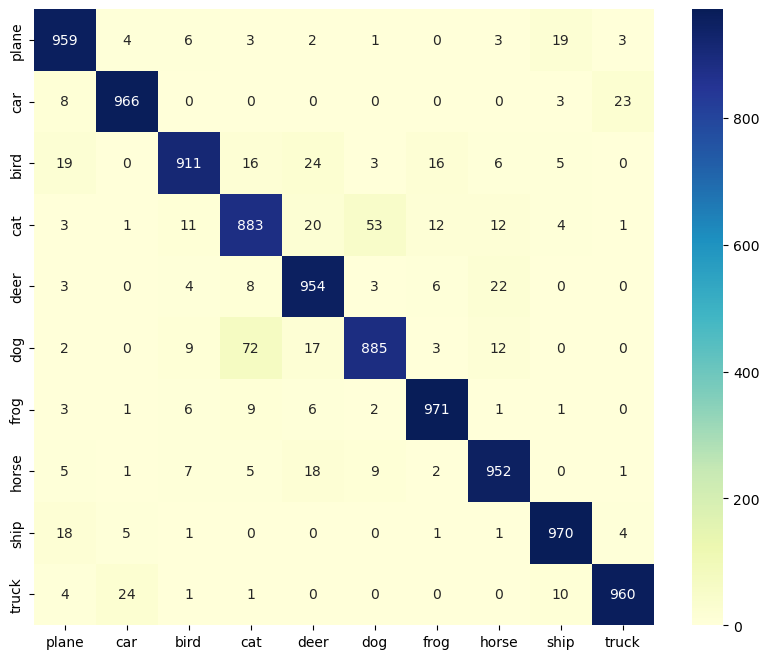

In [44]:
heatmap = pd.DataFrame(data=0,index=classes,columns=classes)
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(batch_size):
            true_label = labels[i].item()
            predicted_label = predicted[i].item()
            heatmap.iloc[true_label,predicted_label] += 1
            
_, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(heatmap, annot=True, fmt="d",cmap="YlGnBu")
plt.show()

In [45]:
path = 'pretrained_VGG16_cifar10.pth'
torch.save(model.state_dict(), path)

## VGG16 TRAINED DIRECTLY ON CIFAR10

In this second part, we define a second VGG16 architecture which hasn't been previously pretrained. However, we still need to modify the last FC-layer by changing the final number of classes. For this reason the code is identical we just load a not pretrained VGG16 Neural network

In [46]:
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10

In [47]:
abs_data_path = 'newpenny/XAI/pytorch/zennit/docs/source/data/CIFAR10'

In [48]:
transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize( 
       (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010) 
    )
])

cifar_dataset = CIFAR10(root=abs_data_path, 
                        train=True, 
                        transform=transform, 
                        download=True)

# split the dataset into train and validation sets
train_size = int(0.8 * len(cifar_dataset))
val_size = len(cifar_dataset) - train_size
train_dataset, val_dataset = random_split(cifar_dataset, [train_size, val_size])

# create DataLoaders
batch_size = 40
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified


In [49]:
use_cuda = torch.cuda.is_available()
cuda_index = torch.cuda.device_count() - 1
device = torch.device(f"cuda:{cuda_index}" if use_cuda else "cpu")
print(f"Using {device} device")

Using cuda:7 device


In [50]:
test_dataset = torchvision.datasets.CIFAR10(root=abs_data_path, 
                                            train=False, 
                                            download=True, 
                                            transform=transform)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


In [51]:
batch_size = 40
learning_rate = 0.001

In [52]:
model = models.vgg16(pretrained = False)
model

/home/lorenzocapelli/miniconda3/envs/tesi/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/lorenzocapelli/miniconda3/envs/tesi/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [53]:
input_lastLayer = model.classifier[6].in_features
model.classifier[6] = nn.Linear(input_lastLayer,10)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr = learning_rate, momentum=0.9,weight_decay=5e-4)


In [54]:
early_stopping_patience = 20
# we set it to infinite at the beeginning any number is smaller than infnite
best_val_loss = float('inf')
patience_counter = 0

In [55]:
def accuracy(outputs, targets):
    _, predicted = torch.max(outputs, 1)  # get the class index with the highest probability
    correct = (predicted == targets).sum().item()
    total = targets.size(0)
    return correct / total

In [56]:
num_epochs = 100
patience_counter = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    for data in train_loader:
        inputs, targets = data
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        correct_predictions += accuracy(outputs, targets) * targets.size(0)
        total_predictions += targets.size(0)

    # Calculate validation loss
    model.eval()
    val_loss = 0.0
    val_correct_predictions = 0
    val_total_predictions = 0
    
    with torch.no_grad():
        for data in val_loader:
            inputs, targets = data
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            
            val_correct_predictions += accuracy(outputs, targets) * targets.size(0)
            val_total_predictions += targets.size(0)
            
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    
    train_accuracy = (correct_predictions / total_predictions) * 100
    val_accuracy = (val_correct_predictions / val_total_predictions) * 100
    
    #print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, '
          f'Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print("Early stopping: Validation loss hasn't improved for", early_stopping_patience, "epochs.")
            break


Epoch [1/100], Train Loss: 1.8967, Val Loss: 1.5789, Train Accuracy: 29.61%, Val Accuracy: 40.89%
Epoch [2/100], Train Loss: 1.4952, Val Loss: 1.3431, Train Accuracy: 45.40%, Val Accuracy: 51.27%
Epoch [3/100], Train Loss: 1.3116, Val Loss: 1.2217, Train Accuracy: 52.56%, Val Accuracy: 56.18%
Epoch [4/100], Train Loss: 1.1444, Val Loss: 1.0391, Train Accuracy: 58.95%, Val Accuracy: 63.68%
Epoch [5/100], Train Loss: 0.9883, Val Loss: 0.9587, Train Accuracy: 65.29%, Val Accuracy: 66.43%
Epoch [6/100], Train Loss: 0.8564, Val Loss: 0.8617, Train Accuracy: 70.02%, Val Accuracy: 69.87%
Epoch [7/100], Train Loss: 0.7514, Val Loss: 0.8368, Train Accuracy: 73.62%, Val Accuracy: 69.78%
Epoch [8/100], Train Loss: 0.6460, Val Loss: 0.7846, Train Accuracy: 77.34%, Val Accuracy: 72.91%
Epoch [9/100], Train Loss: 0.5598, Val Loss: 0.6933, Train Accuracy: 80.51%, Val Accuracy: 76.46%
Epoch [10/100], Train Loss: 0.4668, Val Loss: 0.6750, Train Accuracy: 83.68%, Val Accuracy: 76.73%
Epoch [11/100], Tra

In [57]:
with torch.no_grad():   
    number_corrects = 0
    number_samples = 0    
    for i, (test_images_set , test_labels_set) in enumerate(test_loader):
        test_images_set = test_images_set.to(device)
        test_labels_set = test_labels_set.to(device)
    
        y_predicted = model(test_images_set)        
        labels_predicted = y_predicted.argmax(axis = 1)        
        number_corrects += (labels_predicted==test_labels_set).sum().item()
        number_samples += test_labels_set.size(0)    
    print(f'Overall accuracy {(number_corrects / number_samples)*100}%')

Overall accuracy 78.89%


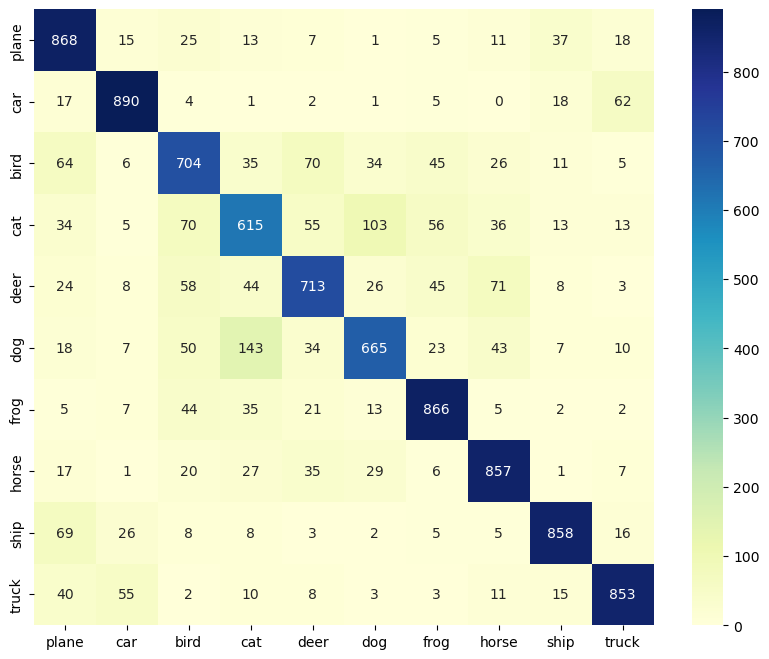

In [58]:
heatmap = pd.DataFrame(data=0,index=classes,columns=classes)
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(batch_size):
            true_label = labels[i].item()
            predicted_label = predicted[i].item()
            heatmap.iloc[true_label,predicted_label] += 1
            
_, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(heatmap, annot=True, fmt="d",cmap="YlGnBu")
plt.show()